In [71]:
"""
Compute efficiency multipliers using the by-loss method and recreate the
bar chart from alg_mult_error_bar.py with the new metric.

This script mirrors the comparisons/plotting of alg_mult_error_bar.py, but
each multiplier is computed as the ratio of compute needed to reach the same
target validation loss (Model B / Model A), aggregated across matching seeds
when available.

Available Functions:
--------------------
1. compute_multiplier_by_loss: Compare two empirical training curves at a target loss
2. compute_multiplier_closest_approach: Compare an empirical curve to a power law fit
   at the point of closest approach (minimum x-axis distance)
"""

'\nCompute efficiency multipliers using the by-loss method and recreate the\nbar chart from alg_mult_error_bar.py with the new metric.\n\nThis script mirrors the comparisons/plotting of alg_mult_error_bar.py, but\neach multiplier is computed as the ratio of compute needed to reach the same\ntarget validation loss (Model B / Model A), aggregated across matching seeds\nwhen available.\n\nAvailable Functions:\n--------------------\n1. compute_multiplier_by_loss: Compare two empirical training curves at a target loss\n2. compute_multiplier_closest_approach: Compare an empirical curve to a power law fit\n   at the point of closest approach (minimum x-axis distance)\n'

In [81]:
import os
import re
import glob
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import util as _importlib_util

In [82]:

# Robust loader to access compute_multiplier_by_loss without static imports


def _get_compute_multiplier_functions():
    """Import both compute_multiplier_by_loss and compute_multiplier_closest_approach."""
    try:
        # Try importing as package module
        import importlib

        module = importlib.import_module(
            "experimental_analysis.compute_multiplier_by_loss"
        )
        return (
            getattr(module, "compute_multiplier_by_loss"),
            getattr(module, "compute_multiplier_closest_approach"),
        )
    except Exception:
        # Load directly from file path (works in both scripts and notebooks)
        # Try multiple possible locations
        possible_paths = [
            # Same directory as notebook/script
            os.path.join(os.getcwd(), "compute_multiplier_by_loss.py"),
            # In experimental_analysis directory
            os.path.join(os.getcwd(), "experimental_analysis", "compute_multiplier_by_loss.py"),
            # Relative to current directory
            "compute_multiplier_by_loss.py",
        ]
        
        # Try using __file__ if available (for scripts)
        try:
            if "__file__" in globals():
                possible_paths.append(os.path.join(os.path.dirname(__file__), "compute_multiplier_by_loss.py"))
        except (NameError, KeyError):
            pass
        
        candidate = None
        for path in possible_paths:
            if os.path.exists(path):
                candidate = path
                break
        
        if candidate is None:
            raise ImportError(
                f"Unable to locate compute_multiplier_by_loss.py. Tried: {possible_paths}"
            )
        
        spec = _importlib_util.spec_from_file_location(
            "compute_multiplier_by_loss", candidate
        )
        if spec is None or spec.loader is None:
            raise ImportError(
                f"Unable to load compute_multiplier_by_loss.py from {candidate}"
            )
        module = _importlib_util.module_from_spec(spec)
        spec.loader.exec_module(module)  # type: ignore[attr-defined]
        return (
            getattr(module, "compute_multiplier_by_loss"),
            getattr(module, "compute_multiplier_closest_approach"),
        )


# Bind the function names used below
compute_multiplier_by_loss, compute_multiplier_closest_approach = (
    _get_compute_multiplier_functions()
)

In [83]:

# ===== EASILY ADJUSTABLE PARAMETERS =====
TARGET_LOSS = 5.30  # Target validation loss at which to compare compute
LOSS_COLUMN = "validation_loss"
CONFIDENCE_INTERVALS = False  # Set to True to display error bars

# Plot font sizes (kept consistent with alg_mult_error_bar.py)
TITLE_FONTSIZE = 20
AXIS_LABEL_FONTSIZE = 20
X_TICK_LABEL_FONTSIZE = 12
Y_TICK_LABEL_FONTSIZE = 16
LEGEND_FONTSIZE = 15
VALUE_LABEL_FONTSIZE = 12
X_TICK_ROTATION = 45


def _get_base_data_path() -> str:
    """Return base path to experimental data, compatible with both run locations."""
    if os.path.exists("../experimental_data_folder/"):
        return "../experimental_data_folder/"
    return "experimental_data_folder/"


def _collect_seeded_files(file_prefix: str) -> Dict[Optional[int], List[str]]:
    """
    Collect CSV files for a given prefix and group them by numeric seed suffix.

    A file is considered seed-tagged if it ends with _<digits>.csv. Files without
    such a suffix are grouped under key None.
    """
    base_path = _get_base_data_path()
    pattern = f"{base_path}{file_prefix}*.csv"
    all_files = glob.glob(pattern)

    seed_regex = re.compile(r"_(\d+)\.csv$")
    grouped: Dict[Optional[int], List[str]] = {}

    for path in all_files:
        match = seed_regex.search(path)
        if match:
            seed = int(match.group(1))
        else:
            seed = None
        grouped.setdefault(seed, []).append(path)

    return grouped


def _pair_seed_files(prefix_a: str, prefix_b: str) -> List[Tuple[str, str]]:
    """
    Pair files from two prefixes by matching seed ids when available.

    Priority:
    - If there are common numeric seeds, pair those (one file per seed per side; if
      multiple files per seed, take them all cross-product).
    - Else, if both sides have only unseeded files (key None), pair them one-to-one
      in sorted order by filename up to min length.
    - Else, if one side has seeded and the other does not, pair unseeded files with
      all seeded files (best-effort pairing).
    """
    grouped_a = _collect_seeded_files(prefix_a)
    grouped_b = _collect_seeded_files(prefix_b)

    seeds_a = set(grouped_a.keys())
    seeds_b = set(grouped_b.keys())

    common_numeric_seeds = [s for s in seeds_a.intersection(seeds_b) if s is not None]

    pairs: List[Tuple[str, str]] = []

    if len(common_numeric_seeds) > 0:
        common_numeric_seeds.sort()
        for s in common_numeric_seeds:
            for fa in sorted(grouped_a.get(s, [])):
                for fb in sorted(grouped_b.get(s, [])):
                    pairs.append((fa, fb))
        return pairs

    # Fallbacks when no common numeric seeds
    files_a_none = sorted(grouped_a.get(None, []))
    files_b_none = sorted(grouped_b.get(None, []))

    if len(files_a_none) > 0 and len(files_b_none) > 0:
        # Pair in order
        for fa, fb in zip(files_a_none, files_b_none):
            pairs.append((fa, fb))
        return pairs

    # Mixed case: one side has seeds, the other does not
    if len(files_a_none) > 0 and len(grouped_b) > 0:
        seeded_b = [f for s, fs in grouped_b.items() if s is not None for f in fs]
        for fa in files_a_none:
            for fb in sorted(seeded_b):
                pairs.append((fa, fb))
        return pairs

    if len(files_b_none) > 0 and len(grouped_a) > 0:
        seeded_a = [f for s, fs in grouped_a.items() if s is not None for f in fs]
        for fb in files_b_none:
            for fa in sorted(seeded_a):
                pairs.append((fa, fb))
        return pairs

    return pairs


def compute_multiplier_estimate_by_loss(
    base_loss_prefix,
    second_loss_prefix,
    target_loss: float,
    loss_column: str = LOSS_COLUMN,
    verbose: bool = False,
) -> Tuple[Optional[float], Optional[float]]:
    """
    Compute the mean by-loss multiplier and its 95% CI across paired files.
    
    Can accept either file prefixes (strings) or numeric compute values (float/int).
    - If both are strings: finds paired files and computes multipliers (original behavior)
    - If one is numeric and one is string: uses numeric value directly, finds files for string prefix
    - If both are numeric: computes single multiplier directly

    Returns (mean_multiplier, error_bar) or (None, None) if no pairs found.
    """
    # Check if inputs are numeric
    is_a_numeric = isinstance(base_loss_prefix, (int, float))
    is_b_numeric = isinstance(second_loss_prefix, (int, float))
    
    # Case 1: Both are numeric - just compute single multiplier
    if is_a_numeric and is_b_numeric:
        try:
            mult, _ = compute_multiplier_by_loss(
                float(base_loss_prefix),
                float(second_loss_prefix),
                target_loss=target_loss,
                loss_column=loss_column,
                verbose=verbose,
            )
            if np.isfinite(mult):
                return float(mult), 0.0
            else:
                return None, None
        except Exception as e:
            if verbose:
                print(f"Error computing multiplier: {e}")
            return None, None
    
    # Case 2: First is numeric, second is string prefix
    if is_a_numeric and not is_b_numeric:
        numeric_value = float(base_loss_prefix)
        # Get all files matching the second prefix
        grouped_b = _collect_seeded_files(second_loss_prefix)
        # Flatten all files
        files_b = []
        for seed, file_list in grouped_b.items():
            files_b.extend(file_list)
        
        if len(files_b) == 0:
            print(f"No files found for prefix '{second_loss_prefix}'.")
            return None, None
        
        if verbose:
            print(f"\nComparing numeric value {numeric_value:.2e} vs {len(files_b)} files from '{second_loss_prefix}'")
        
        multipliers: List[float] = []
        for file_b in files_b:
            try:
                mult, _ = compute_multiplier_by_loss(
                    numeric_value,
                    file_b,
                    target_loss=target_loss,
                    loss_column=loss_column,
                    verbose=False,
                )
                if np.isfinite(mult):
                    multipliers.append(float(mult))
            except Exception as e:
                if verbose:
                    print(f"  Skipping file {os.path.basename(file_b)} due to error: {e}")
                continue
        
        if len(multipliers) == 0:
            print(f"No valid multipliers computed for numeric value {numeric_value:.2e} vs '{second_loss_prefix}'.")
            return None, None
        
        mean_multiplier = float(np.mean(multipliers))
        if len(multipliers) > 1:
            error_bar = float(
                np.std(multipliers, ddof=1) / np.sqrt(len(multipliers)) * 1.96
            )
        else:
            error_bar = 0.0
        
        return mean_multiplier, error_bar
    
    # Case 3: First is string prefix, second is numeric
    if not is_a_numeric and is_b_numeric:
        numeric_value = float(second_loss_prefix)
        # Get all files matching the first prefix
        grouped_a = _collect_seeded_files(base_loss_prefix)
        # Flatten all files
        files_a = []
        for seed, file_list in grouped_a.items():
            files_a.extend(file_list)
        
        if len(files_a) == 0:
            print(f"No files found for prefix '{base_loss_prefix}'.")
            return None, None
        
        if verbose:
            print(f"\nComparing {len(files_a)} files from '{base_loss_prefix}' vs numeric value {numeric_value:.2e}")
        
        multipliers: List[float] = []
        for file_a in files_a:
            try:
                mult, _ = compute_multiplier_by_loss(
                    file_a,
                    numeric_value,
                    target_loss=target_loss,
                    loss_column=loss_column,
                    verbose=False,
                )
                if np.isfinite(mult):
                    multipliers.append(float(mult))
            except Exception as e:
                if verbose:
                    print(f"  Skipping file {os.path.basename(file_a)} due to error: {e}")
                continue
        
        if len(multipliers) == 0:
            print(f"No valid multipliers computed for '{base_loss_prefix}' vs numeric value {numeric_value:.2e}.")
            return None, None
        
        mean_multiplier = float(np.mean(multipliers))
        if len(multipliers) > 1:
            error_bar = float(
                np.std(multipliers, ddof=1) / np.sqrt(len(multipliers)) * 1.96
            )
        else:
            error_bar = 0.0
        
        return mean_multiplier, error_bar
    
    # Case 4: Both are strings - original behavior
    pairs = _pair_seed_files(base_loss_prefix, second_loss_prefix)

    if verbose:
        print(
            f"\nPairing for prefixes '{base_loss_prefix}' vs '{second_loss_prefix}': {len(pairs)} pairs"
        )
        for a, b in pairs[:5]:
            print(f"  {os.path.basename(a)}  <->  {os.path.basename(b)}")
        if len(pairs) > 5:
            print("  ...")

    if len(pairs) == 0:
        print(
            f"No paired files found for prefixes '{base_loss_prefix}' and '{second_loss_prefix}'."
        )
        return None, None

    multipliers: List[float] = []
    for file_a, file_b in pairs:
        try:
            mult, _ = compute_multiplier_by_loss(
                file_a,
                file_b,
                target_loss=target_loss,
                loss_column=loss_column,
                verbose=False,
            )
            if np.isfinite(mult):
                multipliers.append(float(mult))
        except Exception as e:
            if verbose:
                print(f"  Skipping pair due to error: {e}")
            continue

    if len(multipliers) == 0:
        print(
            f"No valid multipliers computed for '{base_loss_prefix}' vs '{second_loss_prefix}'."
        )
        return None, None

    mean_multiplier = float(np.mean(multipliers))
    # 95% CI using standard error
    if len(multipliers) > 1:
        error_bar = float(
            np.std(multipliers, ddof=1) / np.sqrt(len(multipliers)) * 1.96
        )
    else:
        error_bar = 0.0

    return mean_multiplier, error_bar

In [84]:
# Setup plotting style and parameters
sns.set_style("ticks")

# ===== EASILY ADJUSTABLE PARAMETERS =====
confidence_intervals = CONFIDENCE_INTERVALS  # Set to False to hide error bars

# ===== EASILY ADJUSTABLE FONT SIZES =====
title_fontsize = TITLE_FONTSIZE
axis_label_fontsize = AXIS_LABEL_FONTSIZE
x_tick_label_fontsize = X_TICK_LABEL_FONTSIZE
y_tick_label_fontsize = Y_TICK_LABEL_FONTSIZE
legend_fontsize = LEGEND_FONTSIZE
value_label_fontsize = VALUE_LABEL_FONTSIZE
x_tick_rotation = X_TICK_ROTATION

In [95]:
# now trying to do closest approach compute multiplier estimate: 




# Compare two theoretical scaling laws
modern_transformer = (1.9, 88, 0.094)  # (E, A, alpha)
# old_transformer = (1.9, 88, 0.045)

multiplier, details = compute_multiplier_closest_approach(
        "../experimental_data_folder/all_ablations/64d_post.csv",
    modern_transformer,
    verbose=True,
    compute_range=(1e15, 1e18),  # Optional
    num_samples=2000             # Optional
)

print(f"At closest approach, old needs {multiplier:.2f}x compute vs modern")



Loaded ../experimental_data_folder/all_ablations/64d_post.csv: 37 rows

Comparison: CSV vs Power Law
CSV: ../experimental_data_folder/all_ablations/64d_post.csv
Power Law B: Loss = 1.9000 + 8.8000e+01 * C^(-0.0940)

Closest Approach Point:
  Validation Loss: 5.3385
  CSV Compute (A): 9.58e+14 FLOPs
  Power Law Compute (B): 9.55e+14 FLOPs
  X-axis Distance: 3.16e+12 FLOPs
  Row index: 27

Compute Multiplier: 0.997x
Power law B requires 1.003x LESS compute than CSV A at this loss
At closest approach, old needs 1.00x compute vs modern


### AdamW vs Adam

In [76]:



TARGET_LOSS = 5.30
adam_adamw_estimate = compute_multiplier_estimate_by_loss(
     "all_ablations/64d_adam", "all_ablations/64d_adam" ,target_loss=TARGET_LOSS
)
print(adam_adamw_estimate)
# TARGET_LOSS = 5.30
# adam_adamw_estimate = compute_multiplier_estimate_by_loss(
#      "biased_modern/64_modern_40", "all_ablations/64d_adam",target_loss=TARGET_LOSS
# )
# print(adam_adamw_estimate)
self_estimate = compute_multiplier_estimate_by_loss(
     "all_ablations/64d_rms", 1.02e15,target_loss=TARGET_LOSS
)
print(self_estimate)

(1.0, 0.0)
(1.4912280701754386, 0.0)


### Activation Function Estimates

In [77]:

swiglu_gelu_estimate = compute_multiplier_estimate_by_loss(
    "all_ablations/64d_rms", "all_ablations/64d_gelu", target_loss=TARGET_LOSS
)
print(swiglu_gelu_estimate)

(1.128654970760234, 0.0)


In [78]:
swiglu_relu_estimate = compute_multiplier_estimate_by_loss(
    "stanford_mult/64d_rms", "stanford_mult/64d_relu", target_loss=TARGET_LOSS
)
print(swiglu_relu_estimate)

(1.030188679245283, 0.0)


In [79]:


gelu_relu_estimate = compute_multiplier_estimate_by_loss(
    "all_ablations/64d_gelu", "all_ablations/64d_relu", target_loss=TARGET_LOSS
)
print(gelu_relu_estimate)

(0.9559585492227979, 0.0)


In [46]:
# rotary vs sinusoidal (compute and print, but keep manual override in plot if desired)
rotary_sinusoidal_estimate = compute_multiplier_estimate_by_loss(
    "all_ablations/64d_rms", "all_ablations/64d_sinusoidal", target_loss=TARGET_LOSS
)
print(rotary_sinusoidal_estimate)

(1.3508771929824561, 0.0)


### Rotary Encodings

In [47]:
rotary_learned_estimate = compute_multiplier_estimate_by_loss(
    "all_ablations/64d_rms", "all_ablations/64d_learned", target_loss=TARGET_LOSS
)
print(rotary_learned_estimate)

(1.25, 0.0)


In [48]:
# rotary vs learned
rotary_sinusoidal_estimate = compute_multiplier_estimate_by_loss(
    "all_ablations/64d_rms", "all_ablations/64d_sinusoidal", target_loss=TARGET_LOSS
)
print(rotary_sinusoidal_estimate)

(1.3508771929824561, 0.0)


### Normalization Estimates

In [49]:
# post vs pre norm
post_pre_norm_estimate = compute_multiplier_estimate_by_loss(
    "all_ablations/64d_rms", "all_ablations/64d_post", target_loss=TARGET_LOSS
)
print(post_pre_norm_estimate)

rms_vs_layer_estimate = compute_multiplier_estimate_by_loss(
    "all_ablations/64d_rms", "all_ablations/64d_layer", target_loss=TARGET_LOSS
)
print(rms_vs_layer_estimate)

(1.8567251461988303, 0.0)
(1.0497076023391814, 0.0)


In [50]:
# adam vs sgd estimate at bs64
adam_sgd_estimate = compute_multiplier_estimate_by_loss(
    "all_ablations/64d_rms",
    "new_sgd_scaling/64d_sgdbs64",
    target_loss=TARGET_LOSS,
)
print(adam_sgd_estimate)

(3.625730994152047, 0.0)


### Learning Rate Schedulers

In [51]:
# estimate of cosine warmup vs inverse_sqrt
cosine_inverse_sqrt_estimate = compute_multiplier_estimate_by_loss(
    "all_ablations/64d_rms",
    "all_ablations/64d_lr_inverse_sqrt",
    target_loss=TARGET_LOSS,
)
print(cosine_inverse_sqrt_estimate)

(1.0, 0.0)


In [52]:
cosine_v_linear_estimate = compute_multiplier_estimate_by_loss(
    "stanford_mult/64d_rms", "stanford_mult/64d_linear_warmup", target_loss=TARGET_LOSS
)
print(cosine_v_linear_estimate)

(1.0, 0.0)


### LSTM Comparisons

In [53]:
# compare lstm to modern transformer
# TARGET_LOSS = 5.33
# lstm_modern_transformer_estimate = compute_multiplier_estimate_by_loss(
#     "stanford_mult/64d_rms",
#     "/lstm_layer1/80d",
#     target_loss=TARGET_LOSS,
# )



lstm_modern_transformer_estimate = compute_multiplier_estimate_by_loss(
    "all_ablations/64d_rms",
    "/lstm_layer1/80d",
    target_loss=TARGET_LOSS,
)
print(lstm_modern_transformer_estimate)

(5.745614035087719, 0.0)


In [54]:

# lstm to old transforem
# lstm_historical_transformer_estimate = compute_multiplier_estimate_by_loss(
#     "debug_historical_experiments/radford_64transformer_2018_bs64",
#     "/lstm_layer1/80d",
#     target_loss=TARGET_LOSS,
# )

lstm_historical_transformer_estimate = compute_multiplier_estimate_by_loss(
    "retry_historical_experiments/64_all_reset",
    "/lstm_layer1/80d",
    target_loss=TARGET_LOSS,
)
print(lstm_historical_transformer_estimate)

(2.911111111111111, 0.0)


In [55]:

# modern to historical transformer
# modern_historical_transformer_estimate = compute_multiplier_estimate_by_loss(
#     "stanford_mult/64d_rms",
#     "debug_historical_experiments/radford_64transformer_2018_bs64",
#     target_loss=TARGET_LOSS,
# )

modern_historical_transformer_estimate = compute_multiplier_estimate_by_loss(
    "all_ablations/64d_rms",
    "retry_historical_experiments/64_all_reset",
    target_loss=TARGET_LOSS,
)


print(modern_historical_transformer_estimate)

(1.9736842105263157, 0.0)


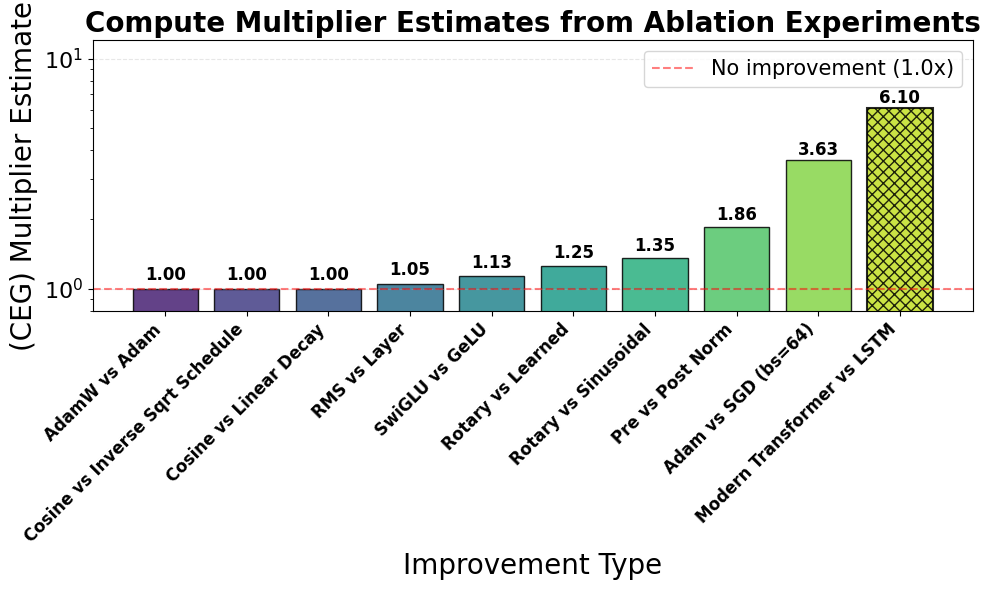


Summary of Compute Multiplier (by-loss) Estimates:
AdamW vs Adam: 1.000x (-0.0% compute efficiency)
Cosine vs Inverse Sqrt Schedule: 1.000x (-0.0% compute efficiency)
Cosine vs Linear Decay: 1.000x (-0.0% compute efficiency)
RMS vs Layer: 1.050x (+5.0% compute efficiency)
SwiGLU vs GeLU: 1.129x (+12.9% compute efficiency)
Rotary vs Learned: 1.250x (+25.0% compute efficiency)
Rotary vs Sinusoidal: 1.351x (+35.1% compute efficiency)
Pre vs Post Norm: 1.857x (+85.7% compute efficiency)
Adam vs SGD (bs=64): 3.626x (+262.6% compute efficiency)
Modern Transformer vs LSTM: 6.100x (+510.0% compute efficiency)


In [67]:
# Create bar plot of compute multiplier estimates with error bars
# estimates_data = [
#     # ("Rotary vs Learned", rotary_learned_estimate)
#     ("Rotary vs Learned", rotary_learned_estimate),  # manual override retained
#     ("SwiGLU vs GeLU", swiglu_gelu_estimate),  # manual override retained
#     ("AdamW vs Adam", adam_adamw_estimate),
#     ("Modern Transformer vs LSTM", lstm_modern_transformer_estimate),
#     ("Cosine vs Inverse Sqrt Schedule", cosine_inverse_sqrt_estimate),
#     # ("Cosine Warmup vs Linear", cosine_v_linear_estimate),
#     ("Adam vs SGD (bs=64)", adam_sgd_estimate),
#     ("Pre vs Post Norm", post_pre_norm_estimate),
#     ("Rotary vs Sinusoidal", rotary_sinusoidal_estimate),
#     ("RMS vs Layer", rms_vs_layer_estimate),
#     ("Cosine vs Linear Decay", cosine_v_linear_estimate),
# ]

estimates_data = [
    # ("Rotary vs Learned", rotary_learned_estimate)
    ("Rotary vs Learned", rotary_learned_estimate),  # manual override retained
    ("SwiGLU vs GeLU", swiglu_gelu_estimate),  # manual override retained
    ("AdamW vs Adam", adam_adamw_estimate),
    ("Modern Transformer vs LSTM", (6.1, 0.0)),
    ("Cosine vs Inverse Sqrt Schedule", cosine_inverse_sqrt_estimate),
    # ("Cosine Warmup vs Linear", cosine_v_linear_estimate),
    ("Adam vs SGD (bs=64)", adam_sgd_estimate),
    ("Pre vs Post Norm", post_pre_norm_estimate),
    ("Rotary vs Sinusoidal", rotary_sinusoidal_estimate),
    ("RMS vs Layer", rms_vs_layer_estimate),
    ("Cosine vs Linear Decay", cosine_v_linear_estimate),
]

CROSS_HATCH_LABEL = "Modern Transformer vs LSTM"


# Filter out None estimates and separate labels, multipliers, and error bars
valid_estimates = [
    (label, data) for label, data in estimates_data if data[0] is not None
]

if valid_estimates:
    # Sort by multiplier so that the highest bar is on the right
    valid_estimates_sorted = sorted(valid_estimates, key=lambda x: x[1][0])

    labels = [item[0] for item in valid_estimates_sorted]
    multipliers = [item[1][0] for item in valid_estimates_sorted]
    error_bars = [item[1][1] for item in valid_estimates_sorted]

    # Choose color palette length to match number of bars (repeat if more than 3)
    palette = sns.color_palette("viridis", n_colors=len(labels))
    bar_colors = palette[: len(labels)]

    plt.figure(figsize=(10, 6))

    # Conditionally add error bars based on confidence_intervals parameter
    if confidence_intervals:
        bars = plt.bar(
            labels,
            multipliers,
            yerr=error_bars,
            capsize=5,
            color=bar_colors,
            alpha=0.85,
            edgecolor="black",
            linewidth=1,
        )
    else:
        bars = plt.bar(
            labels,
            multipliers,
            color=bar_colors,
            alpha=0.85,
            edgecolor="black",
            linewidth=1,
        )
    
    # Apply cross hatching to specified bar if CROSS_HATCH_LABEL is set
    if CROSS_HATCH_LABEL is not None:
        try:
            hatch_idx = labels.index(CROSS_HATCH_LABEL)
            bars[hatch_idx].set_hatch('xxx')  # Cross hatch pattern
            bars[hatch_idx].set_edgecolor('black')
            bars[hatch_idx].set_linewidth(1.5)  # Slightly thicker edge for visibility
        except ValueError:
            print(f"Warning: Label '{CROSS_HATCH_LABEL}' not found in labels. Available labels: {labels}")

    plt.ylabel("(CEG) Multiplier Estimate", fontsize=axis_label_fontsize)
    plt.xlabel("Improvement Type", fontsize=axis_label_fontsize)
    plt.title(
        "Compute Multiplier Estimates from Ablation Experiments",
        fontsize=title_fontsize,
        fontweight="bold",
    )
    # Increase the font size of the x-tick labels for visibility
    plt.xticks(
        rotation=x_tick_rotation,
        ha="right",
        fontsize=x_tick_label_fontsize,  # Use separate parameter
        fontweight="bold",
    )

    # Fix y-axis tick label sizes for log scale
    ax = plt.gca()
    ax.tick_params(axis="y", which="major", labelsize=y_tick_label_fontsize)
    ax.tick_params(axis="y", which="minor", labelsize=y_tick_label_fontsize)

    plt.grid(axis="y", alpha=0.3, linestyle="--")

    # Add value labels on top of bars
    for i, (bar, multiplier, error) in enumerate(zip(bars, multipliers, error_bars)):
        if confidence_intervals:
            plt.text(
                bar.get_x() + bar.get_width() / 2.0,
                bar.get_height() + error + 0.05,
                f"{multiplier:.2f}±{error:.2f}",
                ha="center",
                va="bottom",
                fontsize=value_label_fontsize,
                fontweight="bold",
                color="black",
            )
        else:
            plt.text(
                bar.get_x() + bar.get_width() / 2.0,
                bar.get_height() + 0.05,
                f"{multiplier:.2f}",
                ha="center",
                va="bottom",
                fontsize=value_label_fontsize,
                fontweight="bold",
                color="black",
            )

    # Set log scale before setting limits
    plt.yscale("log")

    # Add a horizontal line at y=1 for reference (no improvement)
    plt.axhline(
        y=1, color="red", linestyle="--", alpha=0.5, label="No improvement (1.0x)"
    )

    # Set y-axis limits appropriate for log scale (cannot start at 0)
    plt.ylim(0.8, 12)
    plt.legend(fontsize=legend_fontsize)

    plt.tight_layout()

    # Create Figures directory if it doesn't exist
    os.makedirs("Figures", exist_ok=True)

    # Save the figure
    plt.savefig(
        "Figures/compute_multiplier_estimates.png", dpi=300, bbox_inches="tight"
    )
    plt.savefig(
        "Figures/compute_multiplier_estimates.pdf", bbox_inches="tight"
    )  # Also save as PDF

    plt.show()

    # Print summary
    print("\nSummary of Compute Multiplier (by-loss) Estimates:")
    print("=" * 50)
    for label, multiplier, error in zip(labels, multipliers, error_bars):
        improvement = (
            ((multiplier - 1) * 100)
            if multiplier > 1
            else (-(1 / multiplier - 1) * 100)
        )
        if confidence_intervals:
            print(
                f"{label}: {multiplier:.3f}x"
                + (f" ± {error:.3f}" if error is not None else "")
                + f" ({improvement:+.1f}% compute efficiency)"
            )
        else:
            print(
                f"{label}: {multiplier:.3f}x ({improvement:+.1f}% compute efficiency)"
            )
else:
    print("No valid estimates found to plot.")

# Stacked Bar Plot

In [57]:
# Fixed version that uses the provided colors instead of viridis
import os

def create_stacked_comparison_plot_2bars(
    stacked_groups, 
    comparison_data, 
    title="Stacked vs Single Comparison",
    bar_order=None,
    save_to_figures=True,
    fig_filename=None,  # If None, will auto-generate name from title
    y_max=None  # If provided, use this as the maximum y-axis value (for consistent scaling across graphs)
):
    """
    Create a 2-bar plot (one comparison, one stacked) with same styling as 4-bar version.
    This function maintains all the same visual properties (heights, widths, text sizes)
    as the original 4-bar graph, just showing 2 bars instead of 4.
    
    Each stacked bar shows cumulative multiplicative effects.
    NOW USES THE PROVIDED COLORS instead of viridis!

    If save_to_figures is True, saves the plot to the Figures subdirectory
    with the filename fig_filename (or auto-generated from title).
    """

    # ===== SAME FONT SIZES AS 4-BAR VERSION =====
    title_fontsize = 25
    axis_label_fontsize = 23
    tick_label_fontsize = 20
    ytick_label_fontsize = 20
    legend_fontsize = 20
    component_label_fontsize = 16
    value_label_fontsize = 17
    total_label_fontsize = 15
    # ========================================
    
    # Same bar width as 4-bar version
    bar_width = 0.75

    # Use matplotlib's default style for cleaner log scale appearance
    plt.style.use('default')

    # Handle bar ordering
    if bar_order is None:
        # Default: comparison first, then stacked
        bar_order = [("comparison", 0)] + [("stacked", 0)]

    # Set up bar positions - only 2 bars
    total_bars = 2
    x_positions = list(range(total_bars))

    # Create labels for each bar in the specified order
    labels = []
    for bar_type, bar_idx in bar_order:
        if bar_type == "stacked":
            components_data = stacked_groups[bar_idx]
            stacked_label = "Stacked:\n" + " \n × ".join(
                [comp[0] for comp in components_data]
            )
            labels.append(stacked_label)
        else:  # comparison
            name, value, color, *_ = comparison_data[bar_idx]
            labels.append(name)

    # Figure size: same height as 4-bar (8), width proportional (8 for 2 bars vs 16 for 4)
    fig = plt.figure(figsize=(8, 8))  # Half width, same height as 4-bar version

    # Plot bars in the specified order
    all_max_values = []  # Track all heights for y-axis scaling

    for plot_idx, (bar_type, bar_idx) in enumerate(bar_order):
        if bar_type == "stacked":
            # Plot stacked bar
            components_data = stacked_groups[bar_idx]
            
            # Calculate cumulative multiplicative heights for this stacked bar
            cumulative_heights = [0.0]  # Start at 0
            running_product = 1.0  # Track the running product of multipliers

            for comp in components_data:
                multiplier = comp[1]
                running_product *= multiplier
                cumulative_heights.append(running_product)

            total_stacked_height = cumulative_heights[-1]
            all_max_values.append(total_stacked_height)

            # Plot stacked components with cumulative multiplicative effects
            for i, comp_data in enumerate(components_data):
                # Unpack with support for optional 5th element (display_name)
                name = comp_data[0]           # Clean name for x-axis labels
                value = comp_data[1]
                color = comp_data[2]
                text_color_val = comp_data[3] if len(comp_data) > 3 else None
                display_name = comp_data[4] if len(comp_data) > 4 else name  # Use display name if provided
                
                bottom = cumulative_heights[i]
                top = cumulative_heights[i + 1]
                segment_height = top - bottom

                # Use the provided color from the data
                bar = plt.bar(
                    x_positions[plot_idx],
                    segment_height,
                    bottom=bottom,
                    color=color,  # Use the provided color
                    width=bar_width,
                    label=(
                        f"{name} ({value:.2f}x)" if plot_idx == 0 else ""
                    ),  # Only label first occurrence
                    alpha=0.85,
                    edgecolor="black",
                    linewidth=0.5,
                )

                # Add component labels in the middle of each segment
                if segment_height > 0.1:  # Only add label if segment is large enough
                    # Position text in the middle of the segment
                    text_y = bottom + segment_height / 2

                    # Ensure text is visible on log scale (at least at y=1.1)
                    # But only adjust if the segment actually crosses the y=1 threshold
                    if bottom < 1.0 and text_y < 1.1 and top > 1.0:
                        text_y = 1.1
                    
                    # Use text color from parameters if provided, otherwise alternate black/white
                    text_color_value = text_color_val if text_color_val else ("white" if i % 2 == 0 else "black")

                    plt.text(
                        x_positions[plot_idx],
                        text_y,
                        f"{display_name} {value:.2f}x",  # Use display_name for in-bar text
                        ha="center",
                        va="center",
                        fontsize=component_label_fontsize,
                        fontweight="bold",
                        color=text_color_value,
                    )

            # Add total height label for this stacked bar
            plt.text(
                x_positions[plot_idx],
                total_stacked_height + 0.2,
                f"Total: {total_stacked_height:.2f}x",
                ha="center",
                va="bottom",
                fontsize=total_label_fontsize,
                fontweight="bold",
                color="black",
            )

        else:  # comparison bar
            # Plot comparison bar
            name, value, color, *text_color = comparison_data[bar_idx]
            
            # Use the provided color from the data
            bar = plt.bar(
                x_positions[plot_idx],
                value,
                color=color,  # Use the provided color
                width=bar_width,
                label=f"{name} ({value:.2f}x)",
                alpha=0.85,
                edgecolor="black",
                linewidth=0.5,
            )

            all_max_values.append(value)

            # Add value labels on top
            plt.text(
                x_positions[plot_idx],
                value + 0.1,
                f"{value:.2f}x",
                ha="center",
                va="bottom",
                fontsize=value_label_fontsize,
                fontweight="bold",
            )

    # Customize plot with same styling as 4-bar version
    plt.xticks(
        x_positions, labels, rotation=0, ha="center", fontsize=tick_label_fontsize
    )
    plt.ylabel(
        "Compute Effect Multiplier (log scale)", fontsize=axis_label_fontsize, fontweight="bold"
    )
    plt.title(title, fontsize=title_fontsize, fontweight="bold")
    
    # Set y-axis limits BEFORE setting log scale
    if y_max is not None:
        # Use provided y_max for consistent scaling across graphs
        plt.ylim(1, y_max * 1.4)
    else:
        # Calculate from data if not provided
        max_value = max(all_max_values) if all_max_values else 2.0
        plt.ylim(1, max_value * 1.4)
    
    # Set log scale - matplotlib will automatically format it properly
    plt.yscale("log")
    
    # Enable grid for both major and minor ticks
    plt.grid(axis="y", linestyle="--", alpha=0.3, which="both")

    # Get axes and configure for standard log scale appearance
    ax = plt.gca()
    
    # Let matplotlib use its default log scale formatting (standard appearance)
    # Just adjust font size and tick appearance
    ax.tick_params(axis="y", which="major", labelsize=ytick_label_fontsize)
    ax.tick_params(axis="y", which="minor", labelsize=0)  # Hide minor tick labels but show ticks

    # Use tight_layout to ensure all content fits, then adjust with fixed padding
    plt.tight_layout()
    # Add consistent padding to ensure all text is visible and dimensions are consistent
    plt.subplots_adjust(left=0.12, right=0.95, top=0.92, bottom=0.12)

    # === Save the plot to the Figures/ folder ===
    if save_to_figures:
        # Find the directory of the notebook or script
        local_dir = os.path.dirname(os.path.abspath(__file__)) if "__file__" in globals() else os.getcwd()
        # Target directory
        figures_dir = os.path.join(local_dir, "Figures")
        os.makedirs(figures_dir, exist_ok=True)
        # Make a nice filename if not supplied
        if fig_filename is None:
            # Slugify the title for filename
            simple_name = title.lower().replace(" ", "_").replace("\n", "_")
            simple_name = "".join([c for c in simple_name if c.isalnum() or c in ("_", "-")])
            fig_filename = f"{simple_name}.png"
        save_path = os.path.join(figures_dir, fig_filename)
        # Use bbox_inches='tight' to include all content, with consistent padding
        # pad_inches adds uniform padding to ensure consistent dimensions
        plt.savefig(save_path, dpi=200, bbox_inches='tight', pad_inches=0.2)
        print(f"Figure saved to: {save_path}")

    plt.show()

    # Print summary
    print(f"\nSummary:")

    # Print each stacked group in the order they appear
    stacked_group_indices = [bar_idx for bar_type, bar_idx in bar_order if bar_type == "stacked"]
    for plot_order, group_idx in enumerate(stacked_group_indices):
        components_data = stacked_groups[group_idx]
        
        # Recalculate cumulative heights for printing
        cumulative_heights = [0.0]
        running_product = 1.0
        for comp in components_data:
            running_product *= comp[1]
            cumulative_heights.append(running_product)

        total_stacked_height = cumulative_heights[-1]

        print(f"\nStacked Group {plot_order + 1} (Position {bar_order.index(('stacked', group_idx)) + 1}) - Total: {total_stacked_height:.2f}x")
        print("  Cumulative breakdown:")
        for i, (name, value, *_) in enumerate(components_data):
            cumulative = cumulative_heights[i + 1]
            print(f"    After {name}: {cumulative:.2f}x (×{value:.2f})")

    # Print comparison values in the order they appear
    comparison_indices = [bar_idx for bar_type, bar_idx in bar_order if bar_type == "comparison"]
    if comparison_indices:
        print(f"\nComparison values:")
        for plot_order, comp_idx in enumerate(comparison_indices):
            name, value, *_ = comparison_data[comp_idx]
            position = bar_order.index(('comparison', comp_idx)) + 1
            print(f"  {name} (Position {position}): {value:.2f}x")


def create_stacked_comparison_plot(
    stacked_groups, 
    comparison_data, 
    title="Stacked vs Single Comparison",
    bar_order=None,
    save_to_figures=True,
    fig_filename=None  # If None, will auto-generate name from title
):
    """
    Create a bar plot with multiple stacked bars and multiple single-value bars.
    Each stacked bar shows cumulative multiplicative effects.
    NOW USES THE PROVIDED COLORS instead of viridis!

    If save_to_figures is True, saves the plot to the Figures subdirectory
    with the filename fig_filename (or auto-generated from title).
    """

    # ===== EASILY ADJUSTABLE FONT SIZES =====
    title_fontsize = 25
    axis_label_fontsize = 23
    tick_label_fontsize = 20
    ytick_label_fontsize = 20
    legend_fontsize = 20
    component_label_fontsize = 16  # Reduced from 18
    value_label_fontsize = 17  # Reduced from 20
    total_label_fontsize = 15  # Reduced from 18
    # ========================================
    
    # Bar width (increased for better text fit)
    bar_width = 0.75  # Increased from 0.6

    # Use matplotlib's default style for cleaner log scale appearance
    # (Seaborn styles can interfere with log scale formatting)
    plt.style.use('default')

    # Handle bar ordering
    if bar_order is None:
        # Default: all stacked groups first, then all comparison items
        bar_order = [("stacked", i) for i in range(len(stacked_groups))] + \
                   [("comparison", i) for i in range(len(comparison_data))]

    # Set up bar positions
    total_bars = len(bar_order)
    x_positions = list(range(total_bars))

    # Create labels for each bar in the specified order
    labels = []
    for bar_type, bar_idx in bar_order:
        if bar_type == "stacked":
            components_data = stacked_groups[bar_idx]
            stacked_label = "Stacked:\n" + " \n × ".join(
                [comp[0] for comp in components_data]
            )
            labels.append(stacked_label)
        else:  # comparison
            name, value, color, *_ = comparison_data[bar_idx]
            labels.append(name)

    # Make figure object so we can save it
    fig = plt.figure(figsize=(16, 8))  # Wide figure for two-column layout

    # Plot bars in the specified order
    all_max_values = []  # Track all heights for y-axis scaling

    for plot_idx, (bar_type, bar_idx) in enumerate(bar_order):
        if bar_type == "stacked":
            # Plot stacked bar
            components_data = stacked_groups[bar_idx]
            
            # Calculate cumulative multiplicative heights for this stacked bar
            cumulative_heights = [0.0]  # Start at 0
            running_product = 1.0  # Track the running product of multipliers

            for comp in components_data:
                multiplier = comp[1]
                running_product *= multiplier
                cumulative_heights.append(running_product)

            total_stacked_height = cumulative_heights[-1]
            all_max_values.append(total_stacked_height)

            # Plot stacked components with cumulative multiplicative effects
            for i, comp_data in enumerate(components_data):
                # Unpack with support for optional 5th element (display_name)
                name = comp_data[0]           # Clean name for x-axis labels
                value = comp_data[1]
                color = comp_data[2]
                text_color_val = comp_data[3] if len(comp_data) > 3 else None
                display_name = comp_data[4] if len(comp_data) > 4 else name  # Use display name if provided
                
                bottom = cumulative_heights[i]
                top = cumulative_heights[i + 1]
                segment_height = top - bottom

                # Use the provided color from the data
                bar = plt.bar(
                    x_positions[plot_idx],
                    segment_height,
                    bottom=bottom,
                    color=color,  # Use the provided color
                    width=bar_width,
                    label=(
                        f"{name} ({value:.2f}x)" if plot_idx == 0 else ""
                    ),  # Only label first occurrence
                    alpha=0.85,
                    edgecolor="black",
                    linewidth=0.5,
                )

                # Add component labels in the middle of each segment
                if segment_height > 0.1:  # Only add label if segment is large enough
                    # Position text in the middle of the segment
                    text_y = bottom + segment_height / 2

                    # Ensure text is visible on log scale (at least at y=1.1)
                    # But only adjust if the segment actually crosses the y=1 threshold
                    if bottom < 1.0 and text_y < 1.1 and top > 1.0:
                        text_y = 1.1
                    
                    # Use text color from parameters if provided, otherwise alternate black/white
                    text_color_value = text_color_val if text_color_val else ("white" if i % 2 == 0 else "black")

                    plt.text(
                        x_positions[plot_idx],
                        text_y,
                        f"{display_name} {value:.2f}x",  # Use display_name for in-bar text
                        ha="center",
                        va="center",
                        fontsize=component_label_fontsize,
                        fontweight="bold",
                        color=text_color_value,
                    )

            # Add total height label for this stacked bar
            plt.text(
                x_positions[plot_idx],
                total_stacked_height + 0.2,
                f"Total: {total_stacked_height:.2f}x",
                ha="center",
                va="bottom",
                fontsize=total_label_fontsize,
                fontweight="bold",
                color="black",
            )

        else:  # comparison bar
            # Plot comparison bar
            name, value, color, *text_color = comparison_data[bar_idx]
            
            # Use the provided color from the data
            bar = plt.bar(
                x_positions[plot_idx],
                value,
                color=color,  # Use the provided color
                width=bar_width,
                label=f"{name} ({value:.2f}x)",
                alpha=0.85,
                edgecolor="black",
                linewidth=0.5,
            )

            all_max_values.append(value)

            # Add value labels on top
            plt.text(
                x_positions[plot_idx],
                value + 0.1,
                f"{value:.2f}x",
                ha="center",
                va="bottom",
                fontsize=value_label_fontsize,
                fontweight="bold",
            )

    # Customize plot with seaborn styling
    plt.xticks(
        x_positions, labels, rotation=0, ha="center", fontsize=tick_label_fontsize
    )
    plt.ylabel(
        "Compute Effect Multiplier (log scale)", fontsize=axis_label_fontsize, fontweight="bold"
    )
    plt.title(title, fontsize=title_fontsize, fontweight="bold")
    
    # Set y-axis limits BEFORE setting log scale
    max_value = max(all_max_values) if all_max_values else 2.0
    plt.ylim(1, max_value * 1.4)
    
    # Set log scale - matplotlib will automatically format it properly
    plt.yscale("log")
    
    # Enable grid for both major and minor ticks
    plt.grid(axis="y", linestyle="--", alpha=0.3, which="both")

    # Get axes and configure for standard log scale appearance
    ax = plt.gca()
    
    # Let matplotlib use its default log scale formatting (standard appearance)
    # Just adjust font size and tick appearance
    ax.tick_params(axis="y", which="major", labelsize=ytick_label_fontsize)
    ax.tick_params(axis="y", which="minor", labelsize=0)  # Hide minor tick labels but show ticks

    plt.tight_layout()

    # === NEW: Save the plot to the Figures/ folder ===
    if save_to_figures:
        # Find the directory of the notebook or script
        local_dir = os.path.dirname(os.path.abspath(__file__)) if "__file__" in globals() else os.getcwd()
        # Target directory
        figures_dir = os.path.join(local_dir, "Figures")
        os.makedirs(figures_dir, exist_ok=True)
        # Make a nice filename if not supplied
        if fig_filename is None:
            # Slugify the title for filename
            simple_name = title.lower().replace(" ", "_").replace("\n", "_")
            simple_name = "".join([c for c in simple_name if c.isalnum() or c in ("_", "-")])
            fig_filename = f"{simple_name}.png"
        save_path = os.path.join(figures_dir, fig_filename)
        plt.savefig(save_path, bbox_inches="tight", dpi=200)
        print(f"Figure saved to: {save_path}")

    plt.show()

    # Print summary
    print(f"\nSummary:")

    # Print each stacked group in the order they appear
    stacked_group_indices = [bar_idx for bar_type, bar_idx in bar_order if bar_type == "stacked"]
    for plot_order, group_idx in enumerate(stacked_group_indices):
        components_data = stacked_groups[group_idx]
        
        # Recalculate cumulative heights for printing
        cumulative_heights = [0.0]
        running_product = 1.0
        for comp in components_data:
            running_product *= comp[1]
            cumulative_heights.append(running_product)

        total_stacked_height = cumulative_heights[-1]

        print(f"\nStacked Group {plot_order + 1} (Position {bar_order.index(('stacked', group_idx)) + 1}) - Total: {total_stacked_height:.2f}x")
        print("  Cumulative breakdown:")
        for i, (name, value, *_) in enumerate(components_data):
            cumulative = cumulative_heights[i + 1]
            print(f"    After {name}: {cumulative:.2f}x (×{value:.2f})")

    # Print comparison values in the order they appear
    comparison_indices = [bar_idx for bar_type, bar_idx in bar_order if bar_type == "comparison"]
    if comparison_indices:
        print(f"\nComparison values:")
        for plot_order, comp_idx in enumerate(comparison_indices):
            name, value, *_ = comparison_data[comp_idx]
            position = bar_order.index(('comparison', comp_idx)) + 1
            print(f"  {name} (Position {position}): {value:.2f}x")


## Stack 1

other_innovations 1.2436491680051105
Figure saved to: /Users/hansgundlach/Documents/MITresearch/Experimental_Progress/experimental_analysis/Figures/interaction_between_algorithmic_components.png


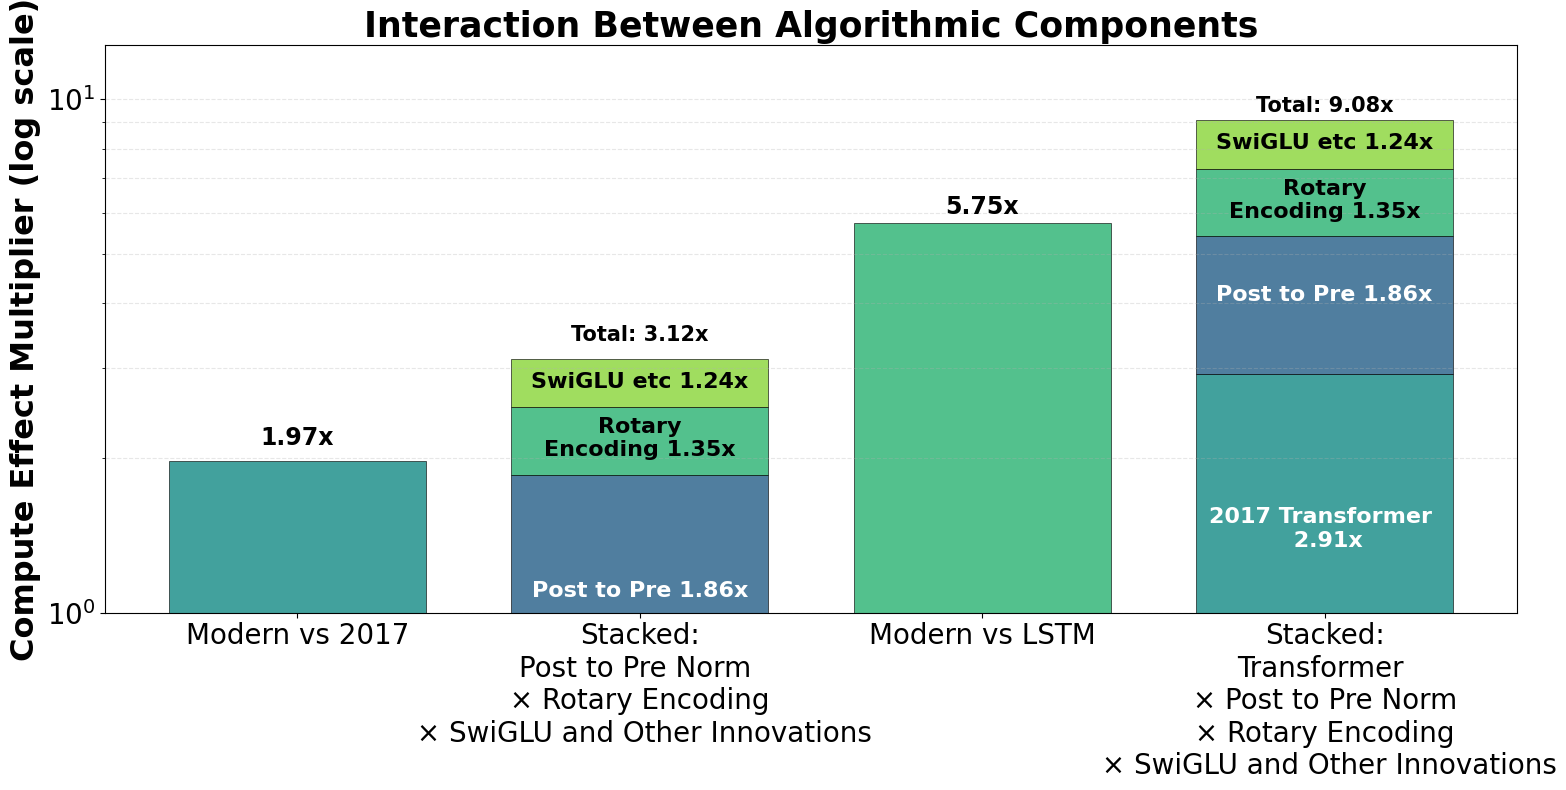


Summary:

Stacked Group 1 (Position 2) - Total: 3.12x
  Cumulative breakdown:
    After Post to Pre Norm: 1.86x (×1.86)
    After Rotary Encoding: 2.51x (×1.35)
    After SwiGLU and Other Innovations: 3.12x (×1.24)

Stacked Group 2 (Position 4) - Total: 9.08x
  Cumulative breakdown:
    After Transformer: 2.91x (×2.91)
    After Post to Pre Norm: 5.41x (×1.86)
    After Rotary Encoding: 7.30x (×1.35)
    After SwiGLU and Other Innovations: 9.08x (×1.24)

Comparison values:
  Modern vs 2017 (Position 1): 1.97x
  Modern vs LSTM (Position 3): 5.75x


In [58]:
# Combined graph with all 4 bars

other_innovations = cosine_inverse_sqrt_estimate[0]*rms_vs_layer_estimate[0]*rms_vs_layer_estimate[0]*swiglu_gelu_estimate[0]
print("other_innovations", other_innovations)
# viridis_colors = ["#440154", "#31688e", "#35b779", "#fde725"]  
viridis_colors = sns.color_palette("viridis", n_colors=5)
stacked_groups_custom = [
    # First stacked bar
    # Format: (clean_name, value, color, text_color, display_name)
    [
        ("Post to Pre Norm", post_pre_norm_estimate[0], viridis_colors[1], "white", "Post to Pre"),
        ("Rotary Encoding", rotary_sinusoidal_estimate[0] , viridis_colors[3], "black", "Rotary\nEncoding"),
        ("SwiGLU and Other Innovations",other_innovations, viridis_colors[4], "black", "SwiGLU etc"),

    ],
    # Second stacked bar 
    [
        ("Transformer", lstm_historical_transformer_estimate[0], viridis_colors[2], "white", "2017 Transformer \n"),
        ("Post to Pre Norm", post_pre_norm_estimate[0], viridis_colors[1], "white", "Post to Pre"),
        ("Rotary Encoding", rotary_sinusoidal_estimate[0], viridis_colors[3], "black", "Rotary\nEncoding"),
        ("SwiGLU and Other Innovations", other_innovations, viridis_colors[4], "black", "SwiGLU etc"),
 
    ],
]
# "#e74c3c"


comparison_data_custom = [
    ("Modern vs 2017", modern_historical_transformer_estimate[0], viridis_colors[2], "white"),
    ("Modern vs LSTM", lstm_modern_transformer_estimate[0], viridis_colors[3], "black"),
]

# Custom order: comparison first, then stacked, then comparison again
custom_bar_order = [
    ("comparison", 0),    # 1st bar: "Current vs 2017" 
    ("stacked", 0),       # 2nd bar: First stacked group (Rotary + SwiGLU)
    ("comparison", 1),    # 3rd bar: "Ho et Al"
    ("stacked", 1),       # 4th bar: Second stacked group (Component A + Component B)
]

create_stacked_comparison_plot(
    stacked_groups_custom,
    comparison_data_custom,
    "Interaction Between Algorithmic Components",
    bar_order=custom_bar_order
)


## Separate Graph 1: Modern Transformer Improvements


other_innovations 1.2436491680051105
Figure saved to: /Users/hansgundlach/Documents/MITresearch/Experimental_Progress/experimental_analysis/Figures/modern_transformer_improvements.png


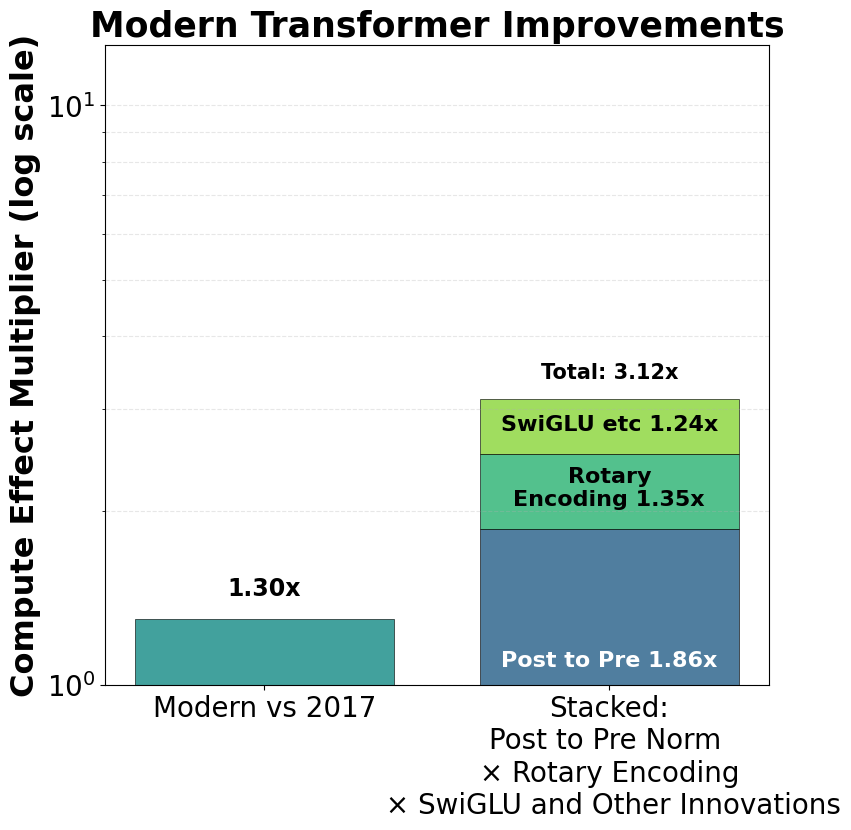


Summary:

Stacked Group 1 (Position 2) - Total: 3.12x
  Cumulative breakdown:
    After Post to Pre Norm: 1.86x (×1.86)
    After Rotary Encoding: 2.51x (×1.35)
    After SwiGLU and Other Innovations: 3.12x (×1.24)

Comparison values:
  Modern vs 2017 (Position 1): 1.30x


In [62]:
# Graph 1: First two bars (Modern vs 2017 comparison + Modern innovations stacked)

other_innovations = cosine_inverse_sqrt_estimate[0]*rms_vs_layer_estimate[0]*rms_vs_layer_estimate[0]*swiglu_gelu_estimate[0]
print("other_innovations", other_innovations)
# viridis_colors = ["#440154", "#31688e", "#35b779", "#fde725"]  
viridis_colors = sns.color_palette("viridis", n_colors=5)

# First graph: Modern vs 2017 comparison + Modern innovations stacked
stacked_groups_graph1 = [
    # Format: (clean_name, value, color, text_color, display_name)
    [
        ("Post to Pre Norm", post_pre_norm_estimate[0], viridis_colors[1], "white", "Post to Pre"),
        ("Rotary Encoding", rotary_sinusoidal_estimate[0] , viridis_colors[3], "black", "Rotary\nEncoding"),
        ("SwiGLU and Other Innovations", other_innovations, viridis_colors[4], "black", "SwiGLU etc"),
    ],
]

# comparison_data_graph1 = [
#     ("Modern vs 2017", modern_historical_transformer_estimate[0], viridis_colors[2], "white"),
# ]

comparison_data_graph1 = [
    ("Modern vs 2017", 1.3, viridis_colors[2], "white"),
]


# Bar order for first graph: comparison first, then stacked
bar_order_graph1 = [
    ("comparison", 0),    # 1st bar: "Modern vs 2017"
    ("stacked", 0),       # 2nd bar: Modern innovations stacked
]

# Set y_max to match both graphs (adjust as needed)
shared_y_max = 9.08  # Maximum value across both graphs

create_stacked_comparison_plot_2bars(
    stacked_groups_graph1,
    comparison_data_graph1,
    "Modern Transformer Improvements",
    bar_order=bar_order_graph1,
    fig_filename="modern_transformer_improvements.png",
    y_max=shared_y_max
)


## Separate Graph 2: Transformer Evolution from LSTM


## Bar Graph 2 

other_innovations 1.2436491680051105
Figure saved to: /Users/hansgundlach/Documents/MITresearch/Experimental_Progress/experimental_analysis/Figures/transformer_evolution_from_lstm.png


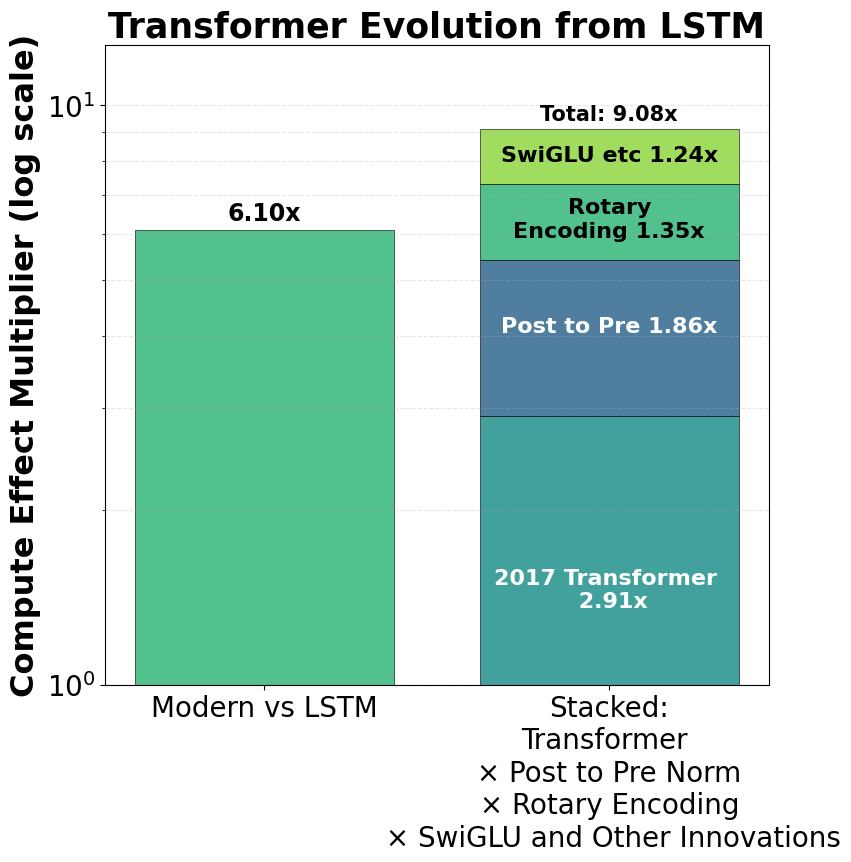


Summary:

Stacked Group 1 (Position 2) - Total: 9.08x
  Cumulative breakdown:
    After Transformer: 2.91x (×2.91)
    After Post to Pre Norm: 5.41x (×1.86)
    After Rotary Encoding: 7.30x (×1.35)
    After SwiGLU and Other Innovations: 9.08x (×1.24)

Comparison values:
  Modern vs LSTM (Position 1): 6.10x


In [61]:
# Graph 2: Second two bars (Modern vs LSTM comparison + Full evolution stacked)

other_innovations = cosine_inverse_sqrt_estimate[0]*rms_vs_layer_estimate[0]*rms_vs_layer_estimate[0]*swiglu_gelu_estimate[0]
print("other_innovations", other_innovations)
# viridis_colors = ["#440154", "#31688e", "#35b779", "#fde725"]  
viridis_colors = sns.color_palette("viridis", n_colors=5)

# Second graph: Modern vs LSTM comparison + Full evolution stacked
stacked_groups_graph2 = [
    # Format: (clean_name, value, color, text_color, display_name)
    [
        ("Transformer", lstm_historical_transformer_estimate[0], viridis_colors[2], "white", "2017 Transformer \n"),
        ("Post to Pre Norm", post_pre_norm_estimate[0], viridis_colors[1], "white", "Post to Pre"),
        ("Rotary Encoding", rotary_sinusoidal_estimate[0], viridis_colors[3], "black", "Rotary\nEncoding"),
        ("SwiGLU and Other Innovations", other_innovations, viridis_colors[4], "black", "SwiGLU etc"),
    ],
]

# comparison_data_graph2 = [
#     ("Modern vs LSTM", lstm_modern_transformer_estimate[0], viridis_colors[3], "black"),
# ]

comparison_data_graph2 = [
    ("Modern vs LSTM", 6.1, viridis_colors[3], "black"),
]

# Bar order for second graph: comparison first, then stacked
bar_order_graph2 = [
    ("comparison", 0),    # 1st bar: "Modern vs LSTM"
    ("stacked", 0),       # 2nd bar: Full evolution stacked (Transformer + all improvements)
]

# Set y_max to match both graphs (adjust as needed)
shared_y_max = 9.08  # Maximum value across both graphs

create_stacked_comparison_plot_2bars(
    stacked_groups_graph2,
    comparison_data_graph2,
    "Transformer Evolution from LSTM",
    bar_order=bar_order_graph2,
    fig_filename="transformer_evolution_from_lstm.png",
    y_max=shared_y_max
)

